In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

2025-03-27 10:06:07.866872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743066367.879839    5112 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743066367.883351    5112 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743066367.892996    5112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743066367.893015    5112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743066367.893017    5112 computation_placer.cc:177] computation placer alr

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("GPU Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA available: True
GPU Device: NVIDIA GeForce RTX 2080 Super with Max-Q Design


In [3]:
ts, dt = (30.0, 0.1)
def simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x, v = 0, 5  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    return torch.tensor(trajectory, device=device)

In [4]:
true_parameter = torch.tensor([1.0, 8.0, 0.8], device=device)
x_obs = simulator(true_parameter).to(device)

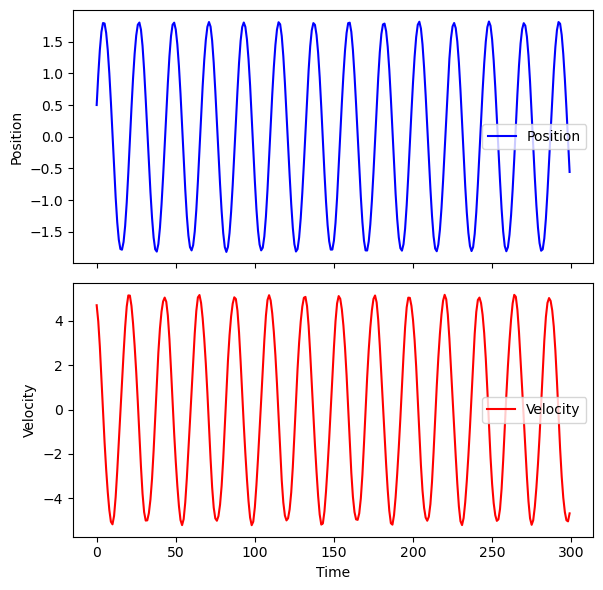

In [5]:
t = torch.arange(len(x_obs))

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t.to("cpu"), x_obs[:, 0].to("cpu"), label="Position", color="b")
axes[0].set_ylabel("Position")
axes[0].legend()

# Plot second column
axes[1].plot(t.to("cpu"), x_obs[:, 1].to("cpu"), label="Velocity", color="r")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [6]:
prior = BoxUniform(low=torch.tensor([0.1, 0.1, 0.1], device=device),
                             high=torch.tensor([10.0, 10.0, 10.0], device=device))

# make a SBI-wrapper on the simulator object for compatibility
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [7]:
num_simulations = 5000
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
theta, x = theta.to(device), x.to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
class LSTMEmbeddingNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=2, output_dim=16, batch_first=True, dropout=0.1):
        super(LSTMEmbeddingNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=batch_first, 
                            dropout=dropout, bidirectional=False)
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # LSTM output shape: (batch, seq_len, hidden_dim * 2) for bidirectional
        output, (h_n, c_n) = self.lstm(x)

        # Combine hidden states from both directions (last layer from both forward and backward)
        h_forward = h_n[-2]  # Last layer's forward hidden state
        h_backward = h_n[-1]  # Last layer's backward hidden state
        summary = torch.cat((h_forward, h_backward), dim=-1)  # Shape: (batch, hidden_dim * 2)

        # Normalize and project using MLP
        summary = self.norm(summary)
        summary = self.mlp(summary)  # Shape: (batch, output_dim)

        return summary

In [9]:
hidden_dim=64
num_layers=2
embedding_net = LSTMEmbeddingNet(hidden_dim=hidden_dim, num_layers=num_layers).to(device)

neural_posterior = posterior_nn(
    model='nsf', 
    embedding_net=embedding_net,
    num_transforms=20,
    use_batch_norm=True,
    )

optimizer = torch.optim.Adam(embedding_net.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=1.2)

inferer = NPE(prior=prior, density_estimator=neural_posterior, device="cuda:0")

/home/sam/miniconda3/envs/pandora/lib/python3.12/site-packages/sbi/neural_nets/factory.py:332: UserWarning: The passed embedding net will be moved to cpu for
                        constructing the net building function.
  check_net_device(embedding_net, "cpu", embedding_net_warn_msg),


In [10]:
# x_flattened = x.view(x.size(0), -1)

In [11]:
inferer.append_simulations(theta, x).train()

 Neural network successfully converged after 42 epochs.

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): PiecewiseRationalQuadraticCouplingTransform(
          (transform_net): ResidualNet(
            (initial_layer): Linear(in_features=17, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x ResidualBlock(
                (batch_norm_layers): ModuleList(
                  (0-1): 2 x BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                )
                (context_layer): Linear(in_features=16, out_features=50, bias=True)
                (linear_layers): ModuleList(
                  (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
                )
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): Linear(in_features=50, out_features=58, bias=True)
          )
        )
        (2): LULinea

In [12]:
posterior = inferer.build_posterior()

In [16]:
# import pickle
# with open(f"./models/LSTM_{num_simulations}.pkl", "wb") as handle:
#     pickle.dump(posterior, handle)

(<Figure size 2000x600 with 2 Axes>,
 array([<Axes: xlabel='epochs_trained', ylabel='training_loss'>,
        <Axes: xlabel='epochs_trained', ylabel='validation_loss'>],
       dtype=object))

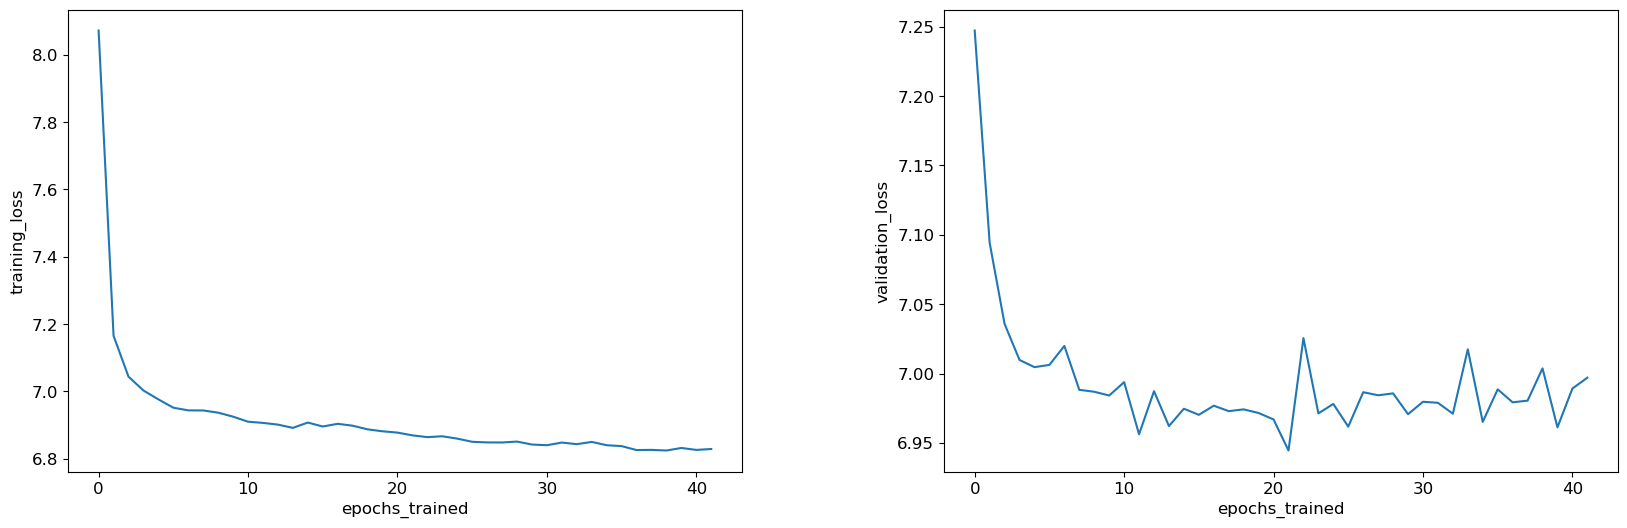

In [13]:
from sbi.analysis import plot_summary
plot_summary(inferer, tags=["training_loss", "validation_loss"])

In [14]:
samples = posterior.sample((1000,), x=x_obs.to(device))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sam/miniconda3/envs/pandora/lib/python3.12/site-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(
/home/sam/miniconda3/envs/pandora/lib/python3.12/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2253.)
  outputs, _ = torch.triangular_solve(


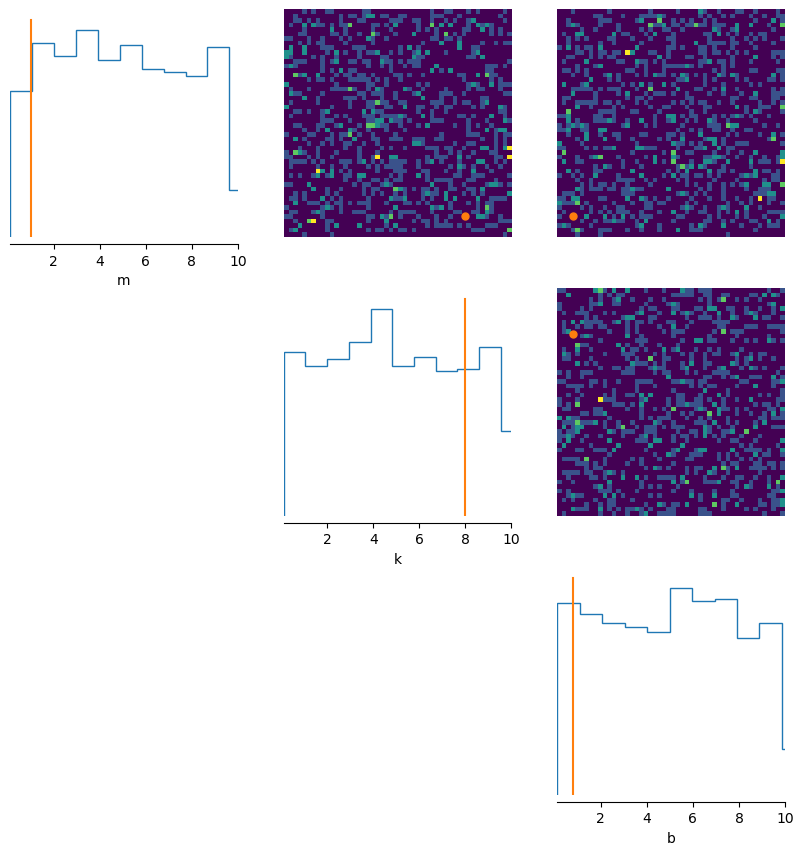

In [16]:
fig, ax = analysis.pairplot(
    samples.to("cpu"),
    points=true_parameter.to("cpu").unsqueeze(0),
    labels=["m", "k", "b"],
    limits=[[0.1, 10], [0.1, 10.0], [0.1, 10.0]]
)

In [32]:
sample = posterior.sample((1,), x=x_obs.to(device))
print(sample)

x_sample = simulator(sample.squeeze()).to("cpu")

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[10.4112,  2.6550,  2.0047]], device='cuda:0')


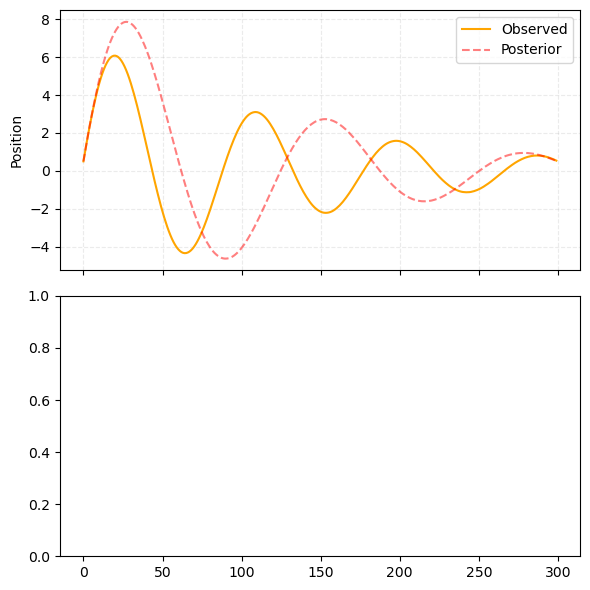

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t.to("cpu"), x_obs[:, 0].to("cpu"), label="Observed",color="orange")
axes[0].plot(t, x_sample[:, 0], label="Posterior", linestyle='--' ,color="red", alpha=0.5)
axes[0].set_ylabel("Position")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.25)

# Show the plots
plt.tight_layout()
plt.show()